<a href="https://colab.research.google.com/github/Rohith1234-sarikela/DS-Intern-Assignment-ROHITH/blob/main/DS-Intern-Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')





























In [40]:
# Load the dataset from a Google Drive URL
url = "https://drive.google.com/uc?export=download&id=1uNIIiifuo-NRNTr2LCKxEgHH4GaFNBFX"
df = pd.read_csv(url)
print("\nInitial Data Shape:", df.shape)



Initial Data Shape: (16857, 29)


In [41]:
df.head()

,timestamp,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,...,zone9_temperature,zone9_humidity,outdoor_temperature,atmospheric_pressure,outdoor_humidity,wind_speed,visibility_index,dew_point,random_variable1,random_variable2
0,2016-01-11 17:00:00,60.0,-77.78778596503064,33.74660933896648,47.59666666666671,19.2,44.790000,19.79,NaN,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60.0,30.0,19.89,46.69333333333329,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50.0,30.0,19.89,46.3,19.2,44.626667,19.79,44.933333,35.921144,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50.0,40.0,33.74660933896648,46.0666666666667,19.2,44.590000,19.79,45.000000,NaN,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,37.673716,45.410389,45.410389
4,2016-01-11 17:40:00,60.0,40.0,19.89,46.33333333333329,19.2,44.530000,19.79,45.000000,18.890000,...,4.476511,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.900000,10.084097,10.084097


In [42]:
# Drop rows with missing values in the target variable to ensure valid targets
df = df.dropna(subset=['equipment_energy_consumption'])

In [43]:
# Replace 'error' and 'unknown' with NaN to handle invalid data
df.replace(['error', 'unknown'], np.nan, inplace=True)

In [44]:
# Convert timestamp to datetime and extract time-based features
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
df = df.drop(columns=['timestamp'])  # Drop timestamp as features are extracted

In [45]:
# Drop irrelevant columns that do not contribute to prediction
df = df.drop(columns=['random_variable1', 'random_variable2'], errors='ignore')


In [46]:
# Split data into features (X) and target (y)
X = df.drop(columns=['equipment_energy_consumption'])
y = df['equipment_energy_consumption']

In [47]:
# Drop columns with all NaNs to prevent preprocessing errors
print("Number of columns in X before dropping all-NaN:", X.shape[1])
X = X.dropna(axis=1, how='all')
print("Number of columns in X after dropping all-NaN:", X.shape[1])

Number of columns in X before dropping all-NaN: 29
Number of columns in X after dropping all-NaN: 29


In [48]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Check for columns with all NaNs in X_train for debugging
print("Columns with all NaNs in X_train:", X_train.columns[X_train.isnull().all()].tolist())


Columns with all NaNs in X_train: []


In [50]:

# Identify numeric and categorical columns for preprocessing
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

In [51]:
# Verify that all columns are accounted for
all_cols = X_train.columns
print("Columns not in numeric or categorical:", list(set(all_cols) - set(numeric_cols) - set(categorical_cols)))

Columns not in numeric or categorical: []


In [52]:
# Define preprocessing for numeric columns: impute with median, then scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [53]:
# Define preprocessing for categorical columns: impute with most frequent, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [54]:
# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [56]:
# Ensure y_train and y_test are numeric
# This handles any non-numeric values in the target variable
y_train = pd.to_numeric(y_train, errors='coerce')
y_train.fillna(y_train.median(), inplace=True)
y_test = pd.to_numeric(y_test, errors='coerce')
y_test.fillna(y_test.median(), inplace=True)

In [57]:
# Check for NaNs in target after preprocessing
# This confirms the target variables are ready for modeling
print("NaNs in y_train after filling:", y_train.isnull().sum())
print("NaNs in y_test after filling:", y_test.isnull().sum())

NaNs in y_train after filling: 0
NaNs in y_test after filling: 0


In [59]:
# Check for non-numeric types
print(X_train.dtypes)

# Check for any non-numeric values like '???' or strings
print(X_train.applymap(type).nunique())

# Check for missing/null values
print("Missing values in X_train:\n", X_train.isnull().sum())

lighting_energy          object
zone1_temperature        object
zone1_humidity           object
zone2_temperature        object
zone2_humidity          float64
zone3_temperature       float64
zone3_humidity          float64
zone4_temperature       float64
zone4_humidity          float64
zone5_temperature       float64
zone5_humidity          float64
zone6_temperature       float64
zone6_humidity          float64
zone7_temperature       float64
zone7_humidity          float64
zone8_temperature       float64
zone8_humidity          float64
zone9_temperature       float64
zone9_humidity          float64
outdoor_temperature     float64
atmospheric_pressure    float64
outdoor_humidity        float64
wind_speed              float64
visibility_index        float64
dew_point               float64
hour                      int32
dayofweek                 int32
month                     int32
is_weekend                int64
dtype: object
lighting_energy         2
zone1_temperature       2
zone1_

In [61]:


# Replace '???' with NaN
X_train.replace('???', np.nan, inplace=True)
X_test.replace('???', np.nan, inplace=True)

# Convert all columns to numeric where possible (optional but safe)
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Fill missing values with column-wise mean
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)


In [62]:
# Perform GridSearchCV with 5-fold cross-validation to find the best hyperparameters
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_regression, k=15)),  # Adjust 'k' if needed
    ('model', RandomForestRegressor(random_state=42))
])

# Define hyperparameter grid
param_grid = {
    'model__n_estimators': [100],
    'model__max_depth': [10],
    'model__min_samples_split': [2]
}

# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('feature_selection',
                                        SelectKBest(k=15,
                                                    score_func=<function f_regression at 0x7846b7600fe0>)),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'model__max_depth': [10],
                         'model__min_samples_split': [2],
                         'model__n_estimators': [100]},
             scoring='r2')

In [64]:
y_pred = grid_search.predict(X_test)

In [65]:
# Evaluate model performance with multiple metrics
print("✅ Best Parameters:", grid_search.best_params_)
print("🎯 R² Score:", r2_score(y_test, y_pred))
print("📉 Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("📏 Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("📊 Cross-Validation R² Score (Mean):", grid_search.best_score_)

✅ Best Parameters: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}
🎯 R² Score: 0.04792305924277018
📉 Mean Squared Error: 31766.004099464186
📏 Mean Absolute Error: 72.76015216864272
📊 Cross-Validation R² Score (Mean): 0.04930330707551327


In [68]:
# Extract selected features and their importances
# This shows which features most influence predictions
all_feature_names = grid_search.best_estimator_.named_steps['scaler'].get_feature_names_out()  # Use 'scaler' instead of 'preprocessor'
selected_features_indices = grid_search.best_estimator_.named_steps['feature_selection'].get_support()
selected_feature_names = all_feature_names[selected_features_indices]

# Get feature importances from the model
importances = grid_search.best_estimator_.named_steps['model'].feature_importances_

# Create a DataFrame to show features and their importances
feature_importance_df = pd.DataFrame({'feature': selected_feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print("\nSelected Features and Their Importances:")
print(feature_importance_df)



Selected Features and Their Importances:
                 feature  importance
14                  hour    0.110241
7         zone6_humidity    0.080295
4      zone3_temperature    0.080105
10        zone9_humidity    0.079560
8      zone8_temperature    0.076494
12  atmospheric_pressure    0.073127
2         zone1_humidity    0.069821
6      zone6_temperature    0.068821
13      outdoor_humidity    0.061688
11   outdoor_temperature    0.060355
3      zone2_temperature    0.053825
9         zone8_humidity    0.050516
5      zone4_temperature    0.050509
1      zone1_temperature    0.045771
0        lighting_energy    0.038872


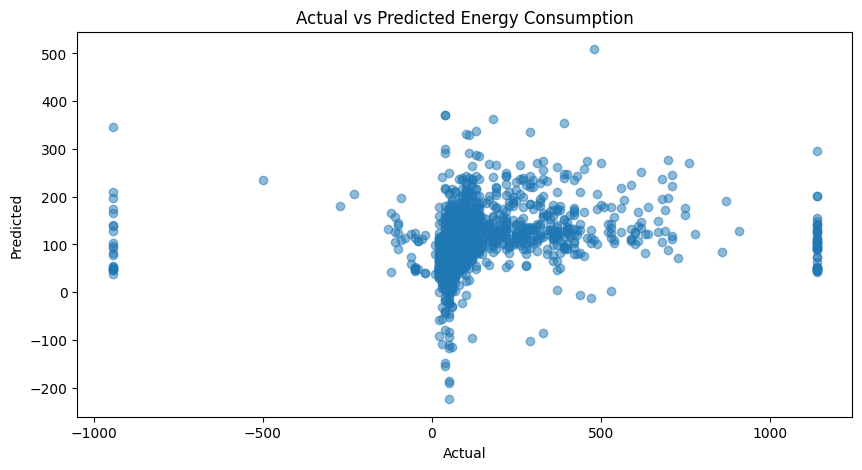

In [73]:
# Visualize actual vs predicted values
# This plot shows how well predictions match actual values
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Energy Consumption")
plt.savefig('actual_vs_predicted.png')
plt.show()


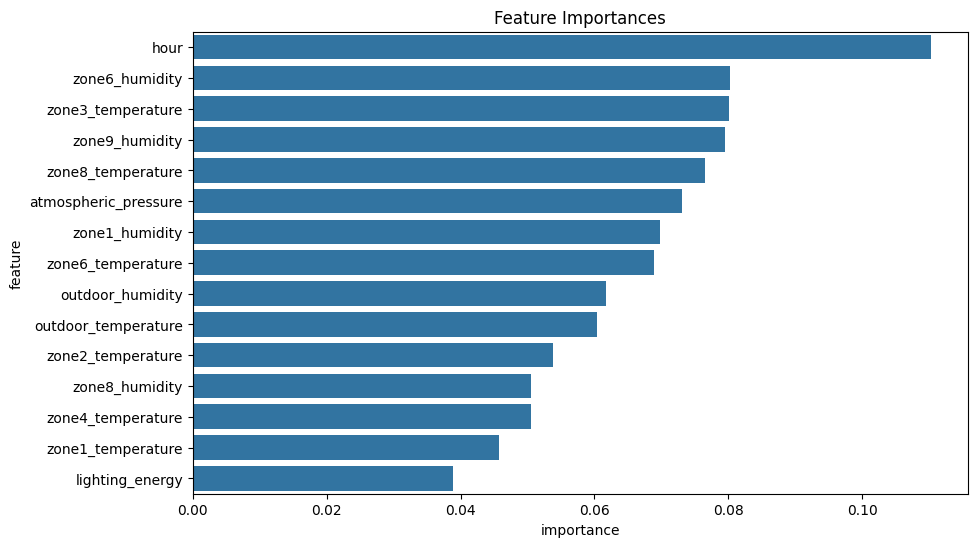

In [74]:
# Visualize feature importances
# This plot highlights the most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title("Feature Importances")
plt.savefig('feature_importances.png')
plt.show()